In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.gridspec import GridSpec
from copulas.multivariate import GaussianMultivariate
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import PchipInterpolator

df = pd.read_excel('filtered-ref-converted.xlsx')

bins = [27.5, 31.5, 33.5, 38]
labels = ['low', 'mid', 'high']

df['bmi_group'] = pd.cut(df['孕妇BMI'], bins=bins, labels=labels, right=True)

# 查看每个区间的数量
print(df['bmi_group'].value_counts())

# 获取各分组的数据
df_low = df[df['bmi_group'] == 'low'].copy()
df_mid = df[df['bmi_group'] == 'mid'].copy()
df_high = df[df['bmi_group'] == 'high'].copy()
df_low['孕妇BMI'].head()


def compute_y_error(df, conc_col='Y染色体浓度', n_col='唯一比对的读段数  ', alpha=0.2):
    """
    计算 Y 染色体浓度标准误差和置信区间

    参数
    ----
    df : pd.DataFrame
        输入数据
    conc_col : str
        Y 染色体浓度列名
    n_col : str
        测序总片段数列名
    alpha : float
        显著性水平, 0.05 -> 95% CI, 0.10 -> 90% CI, 0.20 -> 80% CI

    返回
    ----
    df : pd.DataFrame
        增加 'SE_Y', 'CI_lower', 'CI_upper' 列
    """
    # z 值
    z = norm.ppf(1 - alpha/2)

    p = df[conc_col]
    N = df[n_col]

    # 避免 N=0 或 p 缺失
    se = np.sqrt(p*(1-p)/N)
    se[N <= 0] = np.nan
    se[p.isna()] = np.nan

    df['SE_Y'] = se
    df['CI_lower'] = (p - z*se).clip(0,1)
    df['CI_upper'] = (p + z*se).clip(0,1)

    return df

# 示例调用
df = compute_y_error(df)
print(df.head())

bmi_group
low     407
mid     227
high    214
Name: count, dtype: int64
   序号  孕妇代码  年龄     身高    体重                 末次月经 IVF妊娠      检测日期  检测抽血次数  \
0   1  A001  31  160.0  72.0  2023-02-01 00:00:00  自然受孕  20230429       1   
1   3  A001  31  160.0  73.0  2023-02-01 00:00:00  自然受孕  20230625       3   
2   4  A001  31  160.0  74.0  2023-02-01 00:00:00  自然受孕  20230716       4   
3   5  A002  32  149.0  74.0  2023-11-09 00:00:00  自然受孕  20240219       1   
4   6  A002  32  149.0  76.0  2023-11-09 00:00:00  自然受孕  20240310       2   

          孕周  ...  21号染色体的GC含量  被过滤掉读段数的比例  染色体的非整倍体  怀孕次数  生产次数  胎儿是否健康  \
0  11.857143  ...     0.399399    0.027484       NaN     1     0       是   
1  20.142857  ...     0.399480    0.022312       NaN     1     0       是   
2  22.857143  ...     0.397212    0.023280       NaN     1     0       是   
3  13.857143  ...     0.404868    0.024212       NaN     2     1       否   
4  16.714286  ...     0.399467    0.026017       NaN     2     1       否   

   bmi_g

In [2]:
from scipy.interpolate import PchipInterpolator

# 风险成本
t_points = [10, 12, 24.5]

# 对应风险成本（可按中值或上界设定）
C_points = [0.02, 0.05, 0.40]  # 这里用小数表示 4%, 6%, 15%

# 构建 PCHIP 光滑插值
risk_cost = PchipInterpolator(t_points, C_points)

# 测试绘图
t = np.linspace(10, 24.5, 500)
C = risk_cost(t)

t = np.linspace(10, 24.5, 500)
C = risk_cost(t)

In [3]:
bins = [27.5, 31.25, 33.5, 38]
labels = ['low', 'mid', 'high']
df['bmi_group'] = pd.cut(df['孕妇BMI'], bins=bins, labels=labels, right=True)

# 查看每个区间的数量
print(df['bmi_group'].value_counts())

# 获取各分组的数据
df_low = df[df['bmi_group'] == 'low'].copy()
df_mid = df[df['bmi_group'] == 'mid'].copy()
df_high = df[df['bmi_group'] == 'high'].copy()

weeks = np.arange(10, 24.5, 0.25)

def fit_copula_and_optimize(df_group, lam=0.5, n_samples=5000):
    """
    输入:
        df_group: DataFrame, 至少包含 ['身高','体重','年龄','SE_Y','Y染色体浓度','孕妇BMI','孕周']
        lam: 风险权重
        n_samples: copula采样数量
    输出:
        best_t: 最优孕周
        U_values: 效用函数曲线 (list)
        probabilities: 整体概率曲线 (list)
        samples: copula生成的样本
        prob_pred: 每个样本的个体化预测概率 (array)
    """
    cols = ['身高','体重','年龄','SE_Y','Y染色体浓度','孕妇BMI','孕周']
    data = df_group[cols].dropna()
    
    if len(data) < 30:
        print("数据不足，跳过")
        return None, None, None, None, None

    # Copula 拟合
    copula = GaussianMultivariate()
    copula.fit(data)

    # 从拟合的 copula 里采样大规模数据
    samples = copula.sample(n_samples)

    # -------- 整体优化部分 --------

    U_values = []
    probabilities = []

    for t in weeks:
        bmi_mean = data['孕妇BMI'].mean()
        cond = samples[
            (np.abs(samples['孕周'] - t) <= 0.3) &
            (np.abs(samples['孕妇BMI'] - bmi_mean) <= 1.0)
        ]

        if len(cond) == 0:
            prob = 0
        else:
            prob = np.mean(cond['Y染色体浓度'] >= 0.04)

        probabilities.append(prob)

        # 风险成本
        C = risk_cost(t)
        U = prob - lam * C
        U_values.append(U)

    best_idx = int(np.argmax(U_values))
    best_t = weeks[best_idx]

    # -------- 个体化预测部分 --------
    prob_pred = []
    for _, row in data.iterrows():
        t = row['孕周']
        bmi = row['孕妇BMI']

        cond = samples[
            (np.abs(samples['孕周'] - t) <= 0.3) &
            (np.abs(samples['孕妇BMI'] - bmi) <= 1.0)
        ]

        if len(cond) == 0:
            prob_pred.append(0.0)
        else:
            prob_pred.append(np.mean(cond['Y染色体浓度'] >= 0.04))

    prob_pred = np.array(prob_pred)

    return best_t, U_values, probabilities, samples, prob_pred

best_low, U_low, prob_low, samples_low, prob_pred_low = fit_copula_and_optimize(df_low)
best_mid, U_mid, prob_mid, samples_mid, prob_pred_mid = fit_copula_and_optimize(df_mid)
best_high, U_high, prob_high, samples_high, prob_pred_high = fit_copula_and_optimize(df_high)


bmi_group
low     390
mid     244
high    214
Name: count, dtype: int64


C:\Users\锤子\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_continuous_distns.py:5574: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
C:\Users\锤子\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
C:\Users\锤子\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_continuous_distns.py:5574: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
C:\Users\锤子\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
C:\Users\锤子\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\锤子\A

C:\Users\锤子\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\锤子\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\锤子\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_continuous_distns.py:5574: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
C:\Users\锤子\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
C:\Users\锤子\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_continuous_distns.py:5574: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c*

C:\Users\锤子\AppData\Local\Temp\ipykernel_49544\3220466405.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


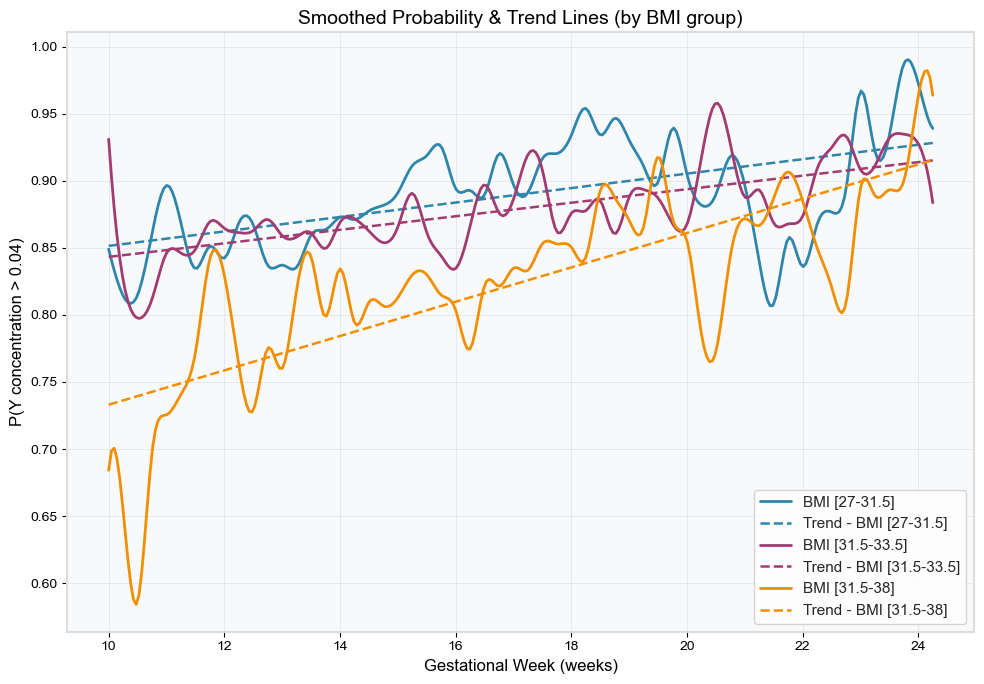

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline
plt.style.use('default')
sns.set_palette("husl")
# -------------------------
# 概率曲线 vs 孕周（单y轴 + 样条平滑 + 趋势直线）
# -------------------------
fig, ax = plt.subplots(figsize=(10, 7))

plt.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
plt.rcParams['font.size'] = 12

weeks = np.arange(10, 24.5, 0.25)


# 平滑函数
def smooth_curve(x, y, num=300):
    x = np.array(x)
    y = np.array(y)
    if len(x) < 4:  # 样条至少要4个点
        return x, y
    x_new = np.linspace(x.min(), x.max(), num)
    spline = make_interp_spline(x, y, k=3)
    y_smooth = spline(x_new)
    return x_new, y_smooth

# 画曲线 + 趋势线的函数
def plot_curve_and_trend(x, y, color, label):
    if y is None:
        return
    # 平滑曲线
    x_new, y_smooth = smooth_curve(x, y)
    ax.plot(x_new, y_smooth, color=color, linewidth=2, label=label)

    # 直线拟合（一次多项式）
    coeffs = np.polyfit(x, y, 1)
    trend = np.poly1d(coeffs)
    ax.plot(x, trend(x), color=color, linestyle="--", linewidth=1.8,
            label=f"Trend - {label}")

# 绘制三条曲线及趋势线#2E86AB #A23B72 #F18F01
plot_curve_and_trend(weeks, prob_low, "#2E86AB", "BMI [27-31.5]")
plot_curve_and_trend(weeks, prob_mid, "#A23B72", "BMI [31.5-33.5]")
plot_curve_and_trend(weeks, prob_high, "#F18F01", "BMI [31.5-38]")

# plot_curve_and_trend(weeks, prob_low, label = "BMI [27-31.5]")
# plot_curve_and_trend(weeks, prob_mid, label="BMI [31.5-33.5]")
# plot_curve_and_trend(weeks, prob_high, label="BMI [31.5-38]")


# 标签与标题
ax.set_xlabel("Gestational Week (weeks)", fontsize=12)
ax.set_ylabel("P(Y concentration > 0.04)", fontsize=12)
ax.set_title("Smoothed Probability & Trend Lines (by BMI group)", fontsize=14)

ax.legend(loc="best", frameon=True, fontsize=11)
ax.grid(alpha=0.3)


# 设置网格和样式
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
plt.gca().set_facecolor('#F8F9FA')

# 美化边框
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('#DDDDDD')

plt.tight_layout()
plt.show()


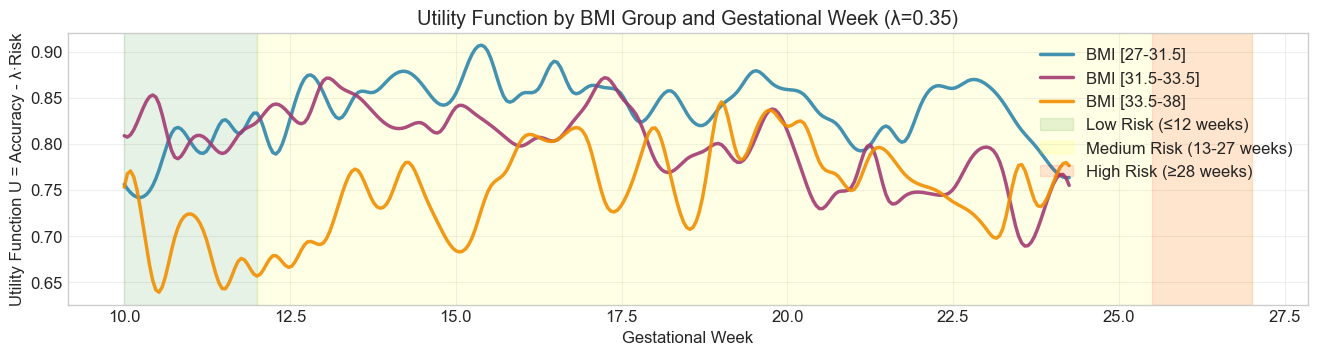

<Figure size 640x480 with 0 Axes>

NIPT TESTING OPTIMIZATION RESULTS
BMI Group    Optimal Week    Risk Level  
------------------------------------------------------------
------------------------------------------------------------
RECOMMENDATIONS:
1. Lower BMI groups can test earlier with good accuracy
2. Higher BMI groups may need to test later for reliable results
3. Consider risk-benefit trade-off when choosing testing time


In [12]:
import warnings
warnings.filterwarnings('ignore')

def plot_U(lam):
    
    best_low, U_low, prob_low, samples_low, prob_pred_low = fit_copula_and_optimize(df_low,lam=lam)
    best_mid, U_mid, prob_mid, samples_mid, prob_pred_mid = fit_copula_and_optimize(df_mid, lam=lam)
    best_high, U_high, prob_high, samples_high, prob_pred_high = fit_copula_and_optimize(df_high, lam=lam)

    
    
    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(3, 2, figure=fig)

# 孕周范围
    weeks = np.arange(10, 24.5, 0.25)

    ax1 = fig.add_subplot(gs[0, :])
    weeks_dense = np.linspace(weeks.min(), weeks.max(), 300)

    if U_low is not None:
    # 使用三次样条插值进行平滑
        spl_low = make_interp_spline(weeks, U_low, k=3)
        U_low_smooth = spl_low(weeks_dense)
        ax1.plot(weeks_dense, U_low_smooth, label=f'BMI [27-31.5]', 
                 linewidth=2.5, color='#2E86AB', alpha=0.9)
    # 标记最优解点
    #ax1.scatter(best_low, spl_low(best_low), color='#2E86AB', s=80, zorder=5, 
     #          edgecolors='white', linewidth=1.5)

    if U_mid is not None:
        spl_mid = make_interp_spline(weeks, U_mid, k=3)
        U_mid_smooth = spl_mid(weeks_dense)
        ax1.plot(weeks_dense, U_mid_smooth, label=f'BMI [31.5-33.5]', 
                 linewidth=2.5, color='#A23B72', alpha=0.9)
    #ax1.scatter(best_mid, spl_mid(best_mid), color='#A23B72', s=80, zorder=5,
     #          edgecolors='white', linewidth=1.5)

    if U_high is not None:
        spl_high = make_interp_spline(weeks, U_high, k=3)
        U_high_smooth = spl_high(weeks_dense)
        ax1.plot(weeks_dense, U_high_smooth, label=f'BMI [33.5-38]', 
                 linewidth=2.5, color='#F18F01', alpha=0.9)
    #ax1.scatter(best_high, spl_high(best_high), color='#F18F01', s=80, zorder=5,
     #          edgecolors='white', linewidth=1.5)


# 标记风险区域
    ax1.axvspan(10, 12, alpha=0.1, color='green', label='Low Risk (≤12 weeks)')
    ax1.axvspan(12, 27, alpha=0.1, color='yellow', label='Medium Risk (13-27 weeks)')
    ax1.axvspan(27, 25.5, alpha=0.1, color='red', label='High Risk (≥28 weeks)')

    ax1.set_xlabel('Gestational Week')
    ax1.set_ylabel('Utility Function U = Accuracy - λ·Risk')
    ax1.set_title(f'Utility Function by BMI Group and Gestational Week (λ={lam})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    plt.show()



plot_U(0.35)



plt.tight_layout()
plt.show()

# 输出结果摘要
print("=" * 60)
print("NIPT TESTING OPTIMIZATION RESULTS")
print("=" * 60)
print(f"{'BMI Group':<12} {'Optimal Week':<15} {'Risk Level':<12}")
print("-" * 60)

"""
for group, week in zip(bmi_groups, best_weeks):
    if week is not None:
        risk = "Low" if week <= 12 else "Medium" if week <= 27 else "High"
        print(f"{group:<12} {week:<15.1f} {risk:<12}")
"""


print("-" * 60)
print("RECOMMENDATIONS:")
print("1. Lower BMI groups can test earlier with good accuracy")
print("2. Higher BMI groups may need to test later for reliable results")
print("3. Consider risk-benefit trade-off when choosing testing time")
print("=" * 60)

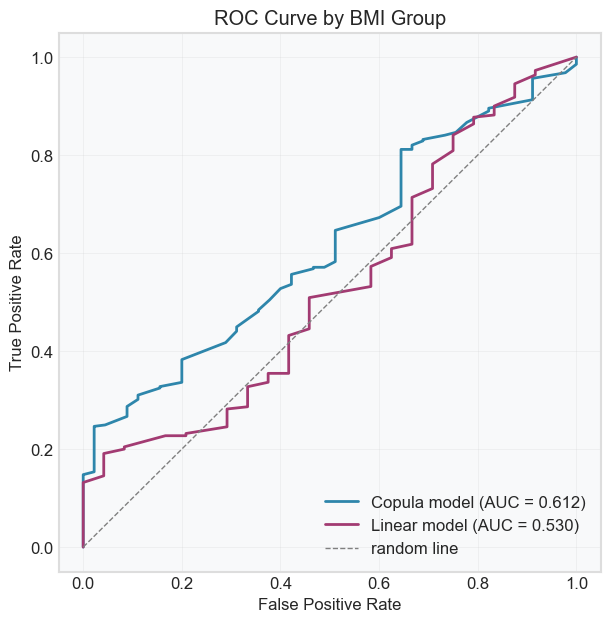

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# 定义函数绘制单组 ROC
def plot_group_roc(df_group, prob_group, label_name, weeks):
    # 插值到每个样本孕周
    prob_interp = np.interp(df_group['孕周'], weeks, prob_group)
    y_true = (df_group['Y染色体浓度'] >= 0.04).astype(int)
    fpr, tpr, _ = roc_curve(y_true, prob_interp)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc, label_name

weeks = np.arange(10, 24.5, 0.25)

# 低 BMI
fpr_low, tpr_low, auc_low, label_low = plot_group_roc(df_low, prob_low, "BMI 低组", weeks)
# 中 BMI
fpr_mid, tpr_mid, auc_mid, label_mid = plot_group_roc(df_mid, prob_mid, "BMI 中组", weeks)
# 高 BMI
fpr_high, tpr_high, auc_high, label_high = plot_group_roc(df_high, prob_high, "BMI 高组", weeks)

# 绘图
plt.figure(figsize=(7,7))
plt.plot(fpr_low, tpr_low, lw=2, label=f'Copula model (AUC = {auc_low:.3f})', color='#2E86AB')
plt.plot(fpr_mid, tpr_mid, lw=2, label=f'Linear model (AUC = {auc_mid:.3f})', color='#A23B72')
# plt.plot(fpr_high, tpr_high, lw=2, label=f'Linear (AUC = {auc_high:.3f})', color='#F18F01')

plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--', label='random line')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by BMI Group')
plt.legend(loc='lower right')

# 设置网格和样式
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
plt.gca().set_facecolor('#F8F9FA')

# 美化边框
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('#DDDDDD')
    
plt.show()
